In [5]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys

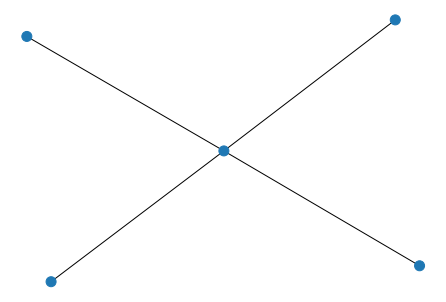

In [6]:
G = nx.star_graph(4)
h = np.zeros(len(G.nodes.keys()))


B_param_init = lambda arr: {list(G.nodes)[i]: arr[i] for i in range(len(list(G.nodes)))}

B_init = B_param_init(h)


nx.set_node_attributes(G,B_init, "exp_field")
nx.draw(G,node_size=(h+1)*100)



In [7]:

def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


def crit_b(J):
    eigenvalues,_ = np.linalg.eig(J)
    return 1./np.max(np.abs(eigenvalues))

def average_degree(control):
    return np.sum([G.degree[i]*con for i,con in enumerate(control)])


In [14]:
        
class mf_ising_system:

    def __init__(self,graph,background_field,fixed_point_iter=int(5*1e4),init_mag='aligned',fp_tol_fac=10-6,
        iim_iter=1000,step_size=1.0,iim_tol_fac=1e-5):
        
        self.graph = graph
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        self.background_field = background_field
        self.fixed_point_iter=fixed_point_iter
        self.iim_iter = iim_iter
        self.fp_tol_fac=fp_tol_fac
        self.iim_tol_fac=iim_tol_fac
        self.step_size=step_size
        if init_mag=='aligned':
            self.init_mag=np.ones(self.graph_size)
        else:
            self.init_mag = init_mag 
            
        
    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = np.dot(self.adj_matrix[i],m)
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term
    
    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(system.graph_size):
            m_new[i]=system.single_mag(i,m_old,beta,field)
        return m_new

    def Steffensen_method(self,mag,beta,field,mag_delta_history,it):      
        # Numerical Analysis Richard L.Burden 9th Edition, p. 107
        
        if len(mag_delta_history)==0:
            mag0=mag
        else:
            mag0=mag_delta_history[it]
        
        for i in range(self.fixed_point_iter):     
            mag1=self.magnetisation(mag0,beta,field)
            mag2=self.magnetisation(mag1,beta,field)   

            if np.all((mag+mag2-2*mag1)!=0):
                mag_d = mag - (mag1-mag)**2/(mag+mag2-2*mag1) 
            else:
                mag_d = mag1
            
            
            if np.sum(abs(mag1-mag_d))<self.fp_tol_fac: 
                break
            if i+1==self.fixed_point_iter:
                print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter')
                mag_d = mag1
                
            mag_delta_history.append(mag_d)
        return mag_d,mag_delta_history
    
    def mag_grad(self,beta,mag):
        # Mean Field Susceptibility;
        
        if all([math.isclose(i,j,abs_tol=1e-5) for i,j in zip(mag,np.ones(len(mag)))]):
            gradient = np.zeros(len(mag))
        else:
            D=np.identity(self.graph_size)*np.array([(1-i**2) for i in mag]) # equals to 0 if all m's are 1 or close to 1
            inv = np.linalg.inv(np.identity(self.graph_size)-beta*D*self.adj_matrix)
            susc_matrix = beta*inv*D
            gradient = np.sum(susc_matrix,axis=1).A1
            gradient = (1.0 / np.linalg.norm(gradient))*gradient #Normalise

        return gradient
    
    
    def MF_IIM(self,field_budget,beta,init_control_field='uniform'):
              
        if init_control_field=='uniform':
            control_field = (field_budget/self.graph_size)*np.ones(self.graph_size)
        else:
            control_field = init_control_field

        # initial magnetisation as influenced by initial budget spread
        # note: different from init_mag which denotes initial magnetisation *without* the external field      
        tot_field = np.array(self.background_field+control_field)

        control_field_history=[]
        control_field_history.append(control_field)
        mag_delta_history=[]
        
        mag_i,mag_delta_history = self.Steffensen_method(self.init_mag,beta,tot_field,mag_delta_history,0)
        
        for it in range(self.iim_iter):
            mag_i_grad = self.mag_grad(beta,mag_i)
            control_field = control_field_history[it]

            control_field_update = (control_field + self.step_size*mag_i_grad)

            control_field_new = projection_simplex_sort(control_field_update.T,z=field_budget)

            
            tot_field = np.array(self.background_field+control_field_new)
            mag_ii,mag_delta_history = self.Steffensen_method(mag_i,beta,tot_field,mag_delta_history,it)


            if np.sum(np.abs(mag_ii-mag_i)) <= self.iim_tol_fac:
                break
            control_field_history.append(control_field_new)
            mag_i=mag_ii
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations'.format(self.iim_iter))
            
        return control_field,it
            
        
                
budget=1.0
h = np.zeros(len(G.nodes.keys()))

system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=int(5*1e4))


beta_crit=crit_b(system.adj_matrix)
beta = 0.9
print(beta_crit)
control,it=system.MF_IIM(budget,beta)


0.5


In [32]:
beta_list = np.logspace(-0.7, 0.5, endpoint=True,num=1000)
y = np.zeros(len(beta_list))
control_history=[]
for beta in beta_list:
    system = mf_ising_system(G,h,iim_iter=1000)
    control,_=system.MF_IIM(budget,beta)
    control_history.append(control)

print('FINISHED')    

Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter
FINISHED


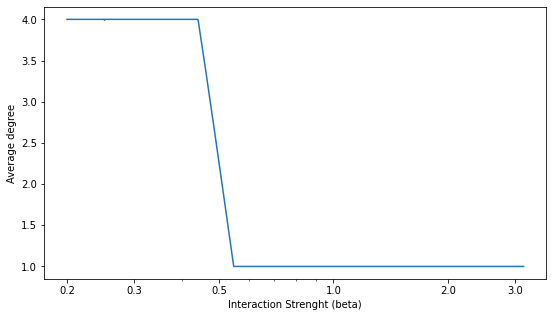

In [36]:
import matplotlib

avs_degrees=np.zeros(len(control_history))
for it,control in enumerate(control_history):
    average_degree = np.sum([G.degree[i]*con for i,con in enumerate(control)])
    avs_degrees[it]=average_degree

fig,ax = plt.subplots(figsize=(9,5))

ax.plot(beta_list,avs_degrees)
ax.set_xscale(value='log')


ax.set_xticks([0.2,0.3,0.5,1.0,2.0, 3.0])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.set_xlabel(r'Interaction Strenght (beta)')
plt.show()


In [37]:
system